In [2]:
import time
import numpy as np
import torch

import src.utils as ut
from src.SCMMappings_1_1 import Abstraction
from src.printing import AbstractionPrinter

import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork as BN
from pgmpy.factors.discrete import TabularCPD as cpd

In [3]:
seed = 0
np.random.seed(seed)  # Numpy module
torch.manual_seed(seed)

In [4]:
from src.examples import smokingmodels as ex

In [9]:
A_basic = Abstraction(*ex.basic_lung_cancer())
A_collapsing = Abstraction(*ex.collapsing_lung_cancer())
A_extended = Abstraction(*ex.extended_lung_cancer())
A_vstruct = Abstraction(*ex.vstruct_lung_cancer())


{'Smoking_': array([[1., 0.],
        [0., 1.]]),
 'Cancer_': array([[1., 0.],
        [0., 1.]])}

In [5]:
import src.evaluationsets as es
import src.learning as lng

In [6]:
J_basic = es.get_causal_sets_in_M1_with_directed_path_in_M1_and_M0(A_basic.M0, A_basic.M1, A_basic.a)

In [7]:
J_collapsing = [[['Smoking_'], ['Tar_']],
 [['Smoking_'], ['Cancer_']],
 [['Tar_'], ['Cancer_']]]

In [8]:
J_extended = [[['Smoking_'], ['Tar_']],
 [['Smoking_'], ['Cancer_']],
 [['Tar_'], ['Cancer_']]]

In [9]:
J_vstruct = [[['Smoking_'], ['Cancer_']],
 [['Smoking_'], ['Fatigue_']],
 [['Cancer_'], ['Fatigue_']]]

In [10]:
from src.nn import JointNeuralNet
from src.nn_losses import JSD_loss,RowMax_penalty

In [11]:
def calc_distance(Ws, alpha_index, alphas):
    distance = 0.0
    for key, value in alphas.items():
        distance += torch.sum(torch.abs(torch.from_numpy(value)-Ws[alpha_index[key]]))
    return distance

In [12]:
def train_a_JointNN_model(M0,M1,R,a,alphas,J,Ws,T,lmbda,num_epochs,lr):
    distances = np.zeros((num_epochs))
    jsds = np.zeros((num_epochs))
    pens = np.zeros((num_epochs))
    end_results = {}
    
    
    model = JointNeuralNet(M0,M1,R,a,J,T)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion_jsd = JSD_loss()
    criterion_pen = RowMax_penalty()
    
    
    for epoch in range(num_epochs):
        lowpaths, highpaths, Ws = model()    
        loss_jsd = criterion_jsd(lowpaths, highpaths)
        loss_pen = criterion_pen(Ws)
        loss = lmbda*loss_jsd + loss_pen
        
        distances[epoch] = calc_distance(Ws, model.alpha_index, alphas)
        jsds[epoch] = loss_jsd
        pens[epoch] = loss_pen

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch+1) % 500 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}, JSD: {:.4f}, Penalty: {:.4f}'.format(epoch+1, num_epochs, loss, loss_jsd, loss_pen))
    
    learnt_alphas = {}
    for name in model.alphas_to_learn:
        learnt_alphas[name] = model.get_Wmatrix_by_name(name).detach()
        
    # discretize alphas and calc_distance
    discretized_alphas = {}
    for name, value in learnt_alphas.items():
        tmp = torch.zeros((value.shape))
        for i in range(value.shape[1]):
            tmp[torch.argmax(value[:,i]),i] = 1
        discretized_alphas[name] = tmp
    
    #calculate distance with discrete learnt alphas
    end_distance = 0.0
    for key, value in alphas.items():
        end_distance += torch.sum(torch.abs(torch.from_numpy(alphas[key])-discretized_alphas[key]))
    
    # jsd and penalty with initalised discrete alphas
    criterion_jsd = JSD_loss()
    criterion_pen = RowMax_penalty()
    end_model = JointNeuralNet(M0,M1,R,a,J,T,initialised_alphas=discretized_alphas)
    lowpaths, highpaths, Ws = end_model()    
    end_loss_jsd = criterion_jsd(lowpaths, highpaths)
    end_loss_pen = criterion_pen(Ws)
    
    # store end results
    end_results['normalised_alphas'] = learnt_alphas
    end_results['discretized_alpha'] = discretized_alphas
    end_results['jsd'] = end_loss_jsd
    end_results['penalty'] = end_loss_pen
    end_results['distance'] = end_distance
    
    return distances/len(alphas), jsds/len(J), pens/len(alphas), end_results

In [13]:
lr = 0.01
num_epochs = 500
T = 0.1
lmbda=10.0
n_fold = 10
k_fold = 10

In [14]:
n_best_distance1 = np.zeros((n_fold,num_epochs))
n_best_jsd1 = np.zeros((n_fold,num_epochs))
n_best_pen1 = np.zeros((n_fold,num_epochs))
n_best_end_results1 = []
n_time1 = np.zeros((n_fold))

n_best_distance2 = np.zeros((n_fold,num_epochs))
n_best_jsd2 = np.zeros((n_fold,num_epochs))
n_best_pen2 = np.zeros((n_fold,num_epochs))
n_best_end_results2 = []
n_time2 = np.zeros((n_fold))

n_best_distance3 = np.zeros((n_fold,num_epochs))
n_best_jsd3 = np.zeros((n_fold,num_epochs))
n_best_pen3 = np.zeros((n_fold,num_epochs))
n_best_end_results3 = []
n_time3 = np.zeros((n_fold))

n_best_distance4 = np.zeros((n_fold,num_epochs))
n_best_jsd4 = np.zeros((n_fold,num_epochs))
n_best_pen4 = np.zeros((n_fold,num_epochs))
n_best_end_results4 = []
n_time4 = np.zeros((n_fold))


for n in range(n_fold):
    print(f"n fold {n+1}:")

    k_distances1 = np.zeros((k_fold,num_epochs))
    k_jsds1 = np.zeros((k_fold,num_epochs))
    k_pens1 = np.zeros((k_fold,num_epochs))
    k_end_results1 = []
    k_time1 = np.zeros((k_fold))
    
    k_distances2 = np.zeros((k_fold,num_epochs))
    k_jsds2 = np.zeros((k_fold,num_epochs))
    k_pens2 = np.zeros((k_fold,num_epochs))
    k_end_results2 = []
    k_time2 = np.zeros((k_fold))
    
    k_distances3 = np.zeros((k_fold,num_epochs))
    k_jsds3 = np.zeros((k_fold,num_epochs))
    k_pens3 = np.zeros((k_fold,num_epochs))
    k_end_results3 = []
    k_time3 = np.zeros((k_fold))
    
    k_distances4 = np.zeros((k_fold,num_epochs))
    k_jsds4 = np.zeros((k_fold,num_epochs))
    k_pens4 = np.zeros((k_fold,num_epochs))
    k_end_results4 = []
    k_time4 = np.zeros((k_fold))
    
    for fold in range(k_fold):
        st = time.time()
        distances_epoch1, jsds1, pens1, end_results1 = train_a_JointNN_model(A_basic.M0, A_basic.M1, A_basic.R, A_basic.a, A_basic.alphas, J_basic,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time1 = et - st
        
        st = time.time()
        distances_epoch2, jsds2, pens2, end_results2 = train_a_JointNN_model(A_collapsing.M0, A_collapsing.M1, A_collapsing.R, A_collapsing.a, A_collapsing.alphas, J_collapsing,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time2 = et - st
        
        st = time.time()
        distances_epoch3, jsds3, pens3, end_results3 = train_a_JointNN_model(A_extended.M0, A_extended.M1, A_extended.R, A_extended.a, A_extended.alphas, J_extended,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time3 = et - st
        
        st = time.time()
        distances_epoch4, jsds4, pens4, end_results4 = train_a_JointNN_model(A_vstruct.M0, A_vstruct.M1, A_vstruct.R, A_vstruct.a, A_vstruct.alphas, J_vstruct,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time4 = et - st
        
        
        k_distances1[fold] = distances_epoch1
        k_jsds1[fold] = jsds1
        k_pens1[fold] = pens1
        k_end_results1.append(end_results1)
        k_time1[fold] = time1
        
        k_distances2[fold] = distances_epoch2
        k_jsds2[fold] = jsds2
        k_pens2[fold] = pens2
        k_end_results2.append(end_results2)
        k_time2[fold] = time2
        
        k_distances3[fold] = distances_epoch3
        k_jsds3[fold] = jsds3
        k_pens3[fold] = pens3
        k_end_results3.append(end_results3)
        k_time3[fold] = time3
        
        k_distances4[fold] = distances_epoch4
        k_jsds4[fold] = jsds4
        k_pens4[fold] = pens4
        k_end_results4.append(end_results4)
        k_time4[fold] = time4
        
    k_losses1 = k_jsds1+k_pens1
    k_losses2 = k_jsds2+k_pens2
    k_losses3 = k_jsds3+k_pens3
    k_losses4 = k_jsds4+k_pens4
    best1 = np.argmin(k_losses1[:,-1])
    best2 = np.argmin(k_losses2[:,-1])
    best3 = np.argmin(k_losses3[:,-1])
    best4 = np.argmin(k_losses4[:,-1])
    
    n_best_distance1[n] = k_distances1[best1]
    n_best_jsd1[n] = k_jsds1[best1]
    n_best_pen1[n] = k_pens1[best1]
    n_best_end_results1.append(k_end_results1[best1])
    n_time1[n] = k_time1[best1]
    
    n_best_distance2[n] = k_distances2[best2]
    n_best_jsd2[n] = k_jsds2[best2]
    n_best_pen2[n] = k_pens2[best2]
    n_best_end_results2.append(k_end_results2[best2])
    n_time2[n] = k_time2[best2]
    
    n_best_distance3[n] = k_distances3[best3]
    n_best_jsd3[n] = k_jsds3[best3]
    n_best_pen3[n] = k_pens3[best3]
    n_best_end_results3.append(k_end_results3[best3])
    n_time3[n] = k_time3[best3]
    
    n_best_distance4[n] = k_distances4[best4]
    n_best_jsd4[n] = k_jsds4[best4]
    n_best_pen4[n] = k_pens4[best4]
    n_best_end_results4.append(k_end_results4[best4])
    n_time4[n] = k_time4[best4]
        
        

n fold 1:
Epoch [500/500], Loss: 0.0050, JSD: 0.0004, Penalty: 0.0006
Epoch [500/500], Loss: 1.9552, JSD: 0.0104, Penalty: 1.8515
Epoch [500/500], Loss: 2.2345, JSD: 0.0278, Penalty: 1.9565
Epoch [500/500], Loss: 2.7749, JSD: 0.2336, Penalty: 0.4387
Epoch [500/500], Loss: 4.2555, JSD: 0.4255, Penalty: 0.0005
Epoch [500/500], Loss: 0.1004, JSD: 0.0027, Penalty: 0.0736
Epoch [500/500], Loss: 0.0209, JSD: 0.0017, Penalty: 0.0039
Epoch [500/500], Loss: 1.3171, JSD: 0.0105, Penalty: 1.2121
Epoch [500/500], Loss: 0.0060, JSD: 0.0004, Penalty: 0.0016
Epoch [500/500], Loss: 1.9601, JSD: 0.0105, Penalty: 1.8552
Epoch [500/500], Loss: 2.5871, JSD: 0.0538, Penalty: 2.0495
Epoch [500/500], Loss: 2.3063, JSD: 0.0089, Penalty: 2.2172
Epoch [500/500], Loss: 2.0112, JSD: 0.0444, Penalty: 1.5676
Epoch [500/500], Loss: 2.0227, JSD: 0.0161, Penalty: 1.8619
Epoch [500/500], Loss: 2.6232, JSD: 0.0700, Penalty: 1.9235
Epoch [500/500], Loss: 1.2365, JSD: 0.0707, Penalty: 0.5299
Epoch [500/500], Loss: 2.0119,

Epoch [500/500], Loss: 0.0088, JSD: 0.0005, Penalty: 0.0037
Epoch [500/500], Loss: 2.0230, JSD: 0.0186, Penalty: 1.8366
Epoch [500/500], Loss: 1.5647, JSD: 0.1563, Penalty: 0.0014
Epoch [500/500], Loss: 3.9323, JSD: 0.2741, Penalty: 1.1914
Epoch [500/500], Loss: 0.0067, JSD: 0.0004, Penalty: 0.0023
Epoch [500/500], Loss: 0.1118, JSD: 0.0038, Penalty: 0.0735
Epoch [500/500], Loss: 1.4973, JSD: 0.0581, Penalty: 0.9164
Epoch [500/500], Loss: 1.3121, JSD: 0.0199, Penalty: 1.1128
Epoch [500/500], Loss: 0.0082, JSD: 0.0005, Penalty: 0.0031
Epoch [500/500], Loss: 2.6730, JSD: 0.0148, Penalty: 2.5252
Epoch [500/500], Loss: 1.4994, JSD: 0.0571, Penalty: 0.9284
Epoch [500/500], Loss: 0.8284, JSD: 0.0050, Penalty: 0.7785
Epoch [500/500], Loss: 0.0059, JSD: 0.0004, Penalty: 0.0015
Epoch [500/500], Loss: 2.0434, JSD: 0.0174, Penalty: 1.8691
Epoch [500/500], Loss: 0.0512, JSD: 0.0025, Penalty: 0.0258
Epoch [500/500], Loss: 1.0602, JSD: 0.0061, Penalty: 0.9993
Epoch [500/500], Loss: 2.0116, JSD: 0.04

Epoch [500/500], Loss: 2.0118, JSD: 0.0455, Penalty: 1.5566
Epoch [500/500], Loss: 3.0264, JSD: 0.0027, Penalty: 2.9990
Epoch [500/500], Loss: 2.4206, JSD: 0.0337, Penalty: 2.0832
Epoch [500/500], Loss: 1.0310, JSD: 0.0024, Penalty: 1.0069
Epoch [500/500], Loss: 1.2721, JSD: 0.0045, Penalty: 1.2272
Epoch [500/500], Loss: 2.5811, JSD: 0.0095, Penalty: 2.4864
Epoch [500/500], Loss: 1.4814, JSD: 0.0436, Penalty: 1.0455
Epoch [500/500], Loss: 3.5513, JSD: 0.2478, Penalty: 1.0730
n fold 8:
Epoch [500/500], Loss: 1.2517, JSD: 0.0020, Penalty: 1.2314
Epoch [500/500], Loss: 1.4866, JSD: 0.1476, Penalty: 0.0103
Epoch [500/500], Loss: 2.0739, JSD: 0.0479, Penalty: 1.5952
Epoch [500/500], Loss: 1.2926, JSD: 0.0074, Penalty: 1.2181
Epoch [500/500], Loss: 0.0076, JSD: 0.0005, Penalty: 0.0029
Epoch [500/500], Loss: 0.0899, JSD: 0.0022, Penalty: 0.0679
Epoch [500/500], Loss: 2.2661, JSD: 0.2099, Penalty: 0.1672
Epoch [500/500], Loss: 3.2485, JSD: 0.2576, Penalty: 0.6728
Epoch [500/500], Loss: 0.0043,

In [15]:
avg_dis1 = np.mean(n_best_distance1,axis=0)
avg_dis_err1 = np.std(n_best_distance1,axis=0)

avg_jsd1 = np.mean(n_best_jsd1,axis=0)
avg_jsd_err1 = np.std(n_best_jsd1,axis=0)

avg_pen1 = np.mean(n_best_pen1,axis=0)
avg_pen_err1 = np.std(n_best_pen1,axis=0)

avg_time1 = np.mean(n_time1,axis=0)
avg_time_err1 = np.std(n_time1,axis=0)

print(f"Basic: Avg Alpha distance: {avg_dis1[-1]}")
print(f"Basic: Avg JSD: {avg_jsd1[-1]}")
print(f"Basic: Avg Penalty: {avg_pen1[-1]}")
print(f"Basic: Avg Time: {avg_time1}")
print(f"Basic: Avg Alpha distance SD: {avg_dis_err1[-1]}")
print(f"Basic: Avg JSD SD: {avg_jsd_err1[-1]}")
print(f"Basic: Avg Penalty SD: {avg_pen_err1[-1]}")
print(f"Basic: Avg Time SD: {avg_time_err1}")


avg_dis2 = np.mean(n_best_distance2,axis=0)
avg_dis_err2 = np.std(n_best_distance2,axis=0)

avg_jsd2 = np.mean(n_best_jsd2,axis=0)
avg_jsd_err2 = np.std(n_best_jsd2,axis=0)

avg_pen2 = np.mean(n_best_pen2,axis=0)
avg_pen_err2 = np.std(n_best_pen2,axis=0)

avg_time2 = np.mean(n_time2,axis=0)
avg_time_err2 = np.std(n_time2,axis=0)

print(f"Collapsing: Avg Alpha distance: {avg_dis2[-1]}")
print(f"Collapsing: Avg JSD: {avg_jsd2[-1]}")
print(f"Collapsing: Avg Penalty: {avg_pen2[-1]}")
print(f"Collapsing: Avg Time: {avg_time2}")
print(f"Collapsing: Avg Alpha distance SD: {avg_dis_err2[-1]}")
print(f"Collapsing: Avg JSD SD: {avg_jsd_err2[-1]}")
print(f"Collapsing: Avg Penalty SD: {avg_pen_err2[-1]}")
print(f"Collapsing: Avg Time SD: {avg_time_err2}")


avg_dis3 = np.mean(n_best_distance3,axis=0)
avg_dis_err3 = np.std(n_best_distance3,axis=0)

avg_jsd3 = np.mean(n_best_jsd3,axis=0)
avg_jsd_err3 = np.std(n_best_jsd3,axis=0)

avg_pen3 = np.mean(n_best_pen3,axis=0)
avg_pen_err3 = np.std(n_best_pen3,axis=0)

avg_time3 = np.mean(n_time3,axis=0)
avg_time_err3 = np.std(n_time3,axis=0)

print(f"Extended: Avg Alpha distance: {avg_dis3[-1]}")
print(f"Extended: Avg JSD: {avg_jsd3[-1]}")
print(f"Extended: Avg Penalty: {avg_pen3[-1]}")
print(f"Extended: Avg Time: {avg_time3}")
print(f"Extended: Avg Alpha distance SD: {avg_dis_err3[-1]}")
print(f"Extended: Avg JSD SD: {avg_jsd_err3[-1]}")
print(f"Extended: Avg Penalty SD: {avg_pen_err3[-1]}")
print(f"Extended: Avg Time SD: {avg_time_err3}")


avg_dis4 = np.mean(n_best_distance4,axis=0)
avg_dis_err4 = np.std(n_best_distance4,axis=0)

avg_jsd4 = np.mean(n_best_jsd4,axis=0)
avg_jsd_err4 = np.std(n_best_jsd4,axis=0)

avg_pen4 = np.mean(n_best_pen4,axis=0)
avg_pen_err4 = np.std(n_best_pen4,axis=0)

avg_time4 = np.mean(n_time4,axis=0)
avg_time_err4 = np.std(n_time4,axis=0)

print(f"Vstruct: Avg Alpha distance: {avg_dis4[-1]}")
print(f"Vstruct: Avg JSD: {avg_jsd4[-1]}")
print(f"Vstruct: Avg Penalty: {avg_pen4[-1]}")
print(f"Vstruct: Avg Time: {avg_time4}")
print(f"Vstruct: Avg Alpha distance SD: {avg_dis_err4[-1]}")
print(f"Vstruct: Avg JSD SD: {avg_jsd_err4[-1]}")
print(f"Vstruct: Avg Penalty SD: {avg_pen_err4[-1]}")
print(f"Vstruct: Avg Time SD: {avg_time_err4}")

Basic: Avg Alpha distance: 0.0005939373360593525
Basic: Avg JSD: 0.0004354681703262031
Basic: Avg Penalty: 0.00029696524143218994
Basic: Avg Time: 0.42730553150177003
Basic: Avg Alpha distance SD: 0.0006927506845643009
Basic: Avg JSD SD: 2.2440093655379803e-05
Basic: Avg Penalty SD: 0.00034638082589747934
Basic: Avg Time SD: 0.0022115374545810134
Collapsing: Avg Alpha distance: 0.08719544747008685
Collapsing: Avg JSD: 0.0007659893909779687
Collapsing: Avg Penalty: 0.022021291653315227
Collapsing: Avg Time: 0.9283046007156373
Collapsing: Avg Alpha distance SD: 0.0033413405147156064
Collapsing: Avg JSD SD: 0.00016131676991950388
Collapsing: Avg Penalty SD: 0.0013519053989770962
Collapsing: Avg Time SD: 0.008238051529881359
Extended: Avg Alpha distance: 0.14046071325428783
Extended: Avg JSD: 0.005632963594204435
Extended: Avg Penalty: 0.002222263813018799
Extended: Avg Time: 0.9382249116897583
Extended: Avg Alpha distance SD: 0.40700111303262393
Extended: Avg JSD SD: 0.015274054626570128


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


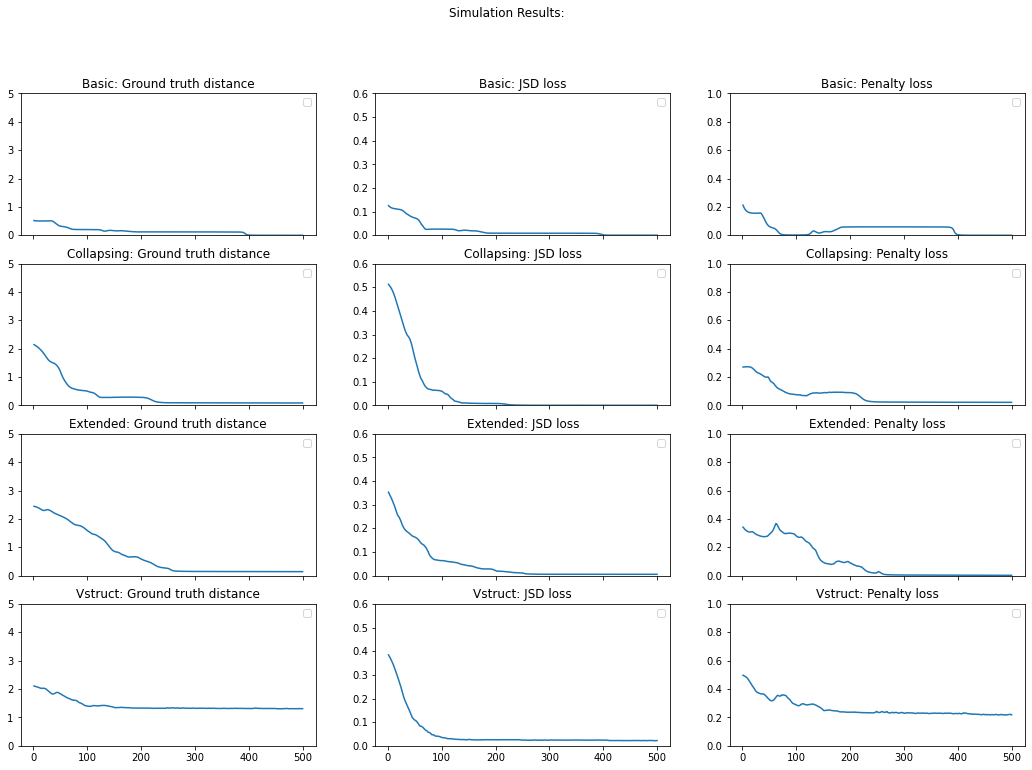

In [16]:

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax8), (ax9, ax10, ax11)) = plt.subplots(nrows=4, ncols=3, sharex=True,
                                    figsize=(18, 12))
time_epoch = np.array([i+1 for i in range(num_epochs)])
ax0.set_title('Basic: Ground truth distance')
ax0.plot(time_epoch, avg_dis1)
ax0.set_ylim([0,5])
ax0.legend()

ax1.set_title('Basic: JSD loss')
ax1.plot(time_epoch, avg_jsd1)
ax1.set_ylim([0,0.6])
ax1.legend()

ax2.set_title('Basic: Penalty loss')
ax2.plot(time_epoch, avg_pen1)
ax2.set_ylim([0,1])
ax2.legend()

ax3.set_title('Collapsing: Ground truth distance')
ax3.plot(time_epoch, avg_dis2)
ax3.set_ylim([0,5])
ax3.legend()

ax4.set_title('Collapsing: JSD loss')
ax4.plot(time_epoch, avg_jsd2)
ax4.set_ylim([0,0.6])
ax4.legend()

ax5.set_title('Collapsing: Penalty loss')
ax5.plot(time_epoch, avg_pen2)
ax5.set_ylim([0,1])
ax5.legend()

ax6.set_title('Extended: Ground truth distance')
ax6.plot(time_epoch, avg_dis3)
ax6.set_ylim([0,5])
ax6.legend()

ax7.set_title('Extended: JSD loss')
ax7.plot(time_epoch, avg_jsd3)
ax7.set_ylim([0,0.6])
ax7.legend()

ax8.set_title('Extended: Penalty loss')
ax8.plot(time_epoch, avg_pen3)
ax8.set_ylim([0,1])
ax8.legend()

ax9.set_title('Vstruct: Ground truth distance')
ax9.plot(time_epoch, avg_dis4)
ax9.set_ylim([0,5])
ax9.legend()

ax10.set_title('Vstruct: JSD loss')
ax10.plot(time_epoch, avg_jsd4)
ax10.set_ylim([0,0.6])
ax10.legend()

ax11.set_title('Vstruct: Penalty loss')
ax11.plot(time_epoch, avg_pen4)
ax11.set_ylim([0,1])
ax11.legend()

fig.suptitle('Simulation Results:')
plt.show()

In [17]:
# Save results
np.save('./results/synthetic/a/avg-best-distance-app3-basic', n_best_distance1)
np.save('./results/synthetic/a/avg-best-JSD-app3-basic', n_best_jsd1)
np.save('./results/synthetic/a/avg-best-penalty-app3-basic', n_best_pen1)
np.save('./results/synthetic/a/avg-best-time-app3-basic', n_time1)
np.save('./results/synthetic/a/avg-best-endresults-app3-basic', n_best_end_results1)

np.save('./results/synthetic/a/avg-best-distance-app3-collapsing', n_best_distance2)
np.save('./results/synthetic/a/avg-best-JSD-app3-collapsing', n_best_jsd2)
np.save('./results/synthetic/a/avg-best-penalty-app3-collapsing', n_best_pen2)
np.save('./results/synthetic/a/avg-best-time-app3-collapsing', n_time2)
np.save('./results/synthetic/a/avg-best-endresults-app3-collapsing', n_best_end_results2)

np.save('./results/synthetic/a/avg-best-distance-app3-extended', n_best_distance3)
np.save('./results/synthetic/a/avg-best-JSD-app3-extended', n_best_jsd3)
np.save('./results/synthetic/a/avg-best-penalty-app3-extended', n_best_pen3)
np.save('./results/synthetic/a/avg-best-time-app3-extended', n_time3)
np.save('./results/synthetic/a/avg-best-endresults-app3-extended', n_best_end_results3)

np.save('./results/synthetic/a/avg-best-distance-app3-vstruct', n_best_distance4)
np.save('./results/synthetic/a/avg-best-JSD-app3-vstruct', n_best_jsd4)
np.save('./results/synthetic/a/avg-best-penalty-app3-vstruct', n_best_pen4)
np.save('./results/synthetic/a/avg-best-time-app3-vstruct', n_time4)
np.save('./results/synthetic/a/avg-best-endresults-app3-vstruct', n_best_end_results4)